calculating and plotting transitions...


done in 1.67s                                                                 
calculating and plotting transitions...
done in 1.97s                                                                 
Resonator-Spin crossings                                                      
Field(mT)	Frequency(GHz)	gamma/gamma_e	Matrix element	df/dA		P max		Optimum Temp (K)
7.58		7.54741		0.81		5.44		-4.9993		0.0782		0.192
10.01		7.5474		0.62		7.25		-4.9978		0.0782		0.192
325.07		7.52705		0.62		7.27		-1.2755		0.0782		0.192
14.48		7.54738		0.44		8.31		-4.9939		0.0782		0.192
224.52		7.5377		0.44		8.32		-3.2267		0.0782		0.192
130.03		7.54416		0.29		8.88		-4.4066		0.0782		0.192
25.02		7.5473		0.29		8.88		-4.9793		0.0782		0.192
57.06		7.54679		0.21		9.06		-4.8869		0.0782		0.192

Resonator-Spin crossings                                                      
Field(mT)	Frequency(GHz)	gamma/gamma_e	Matrix element	df/dA		P max		Optimum Temp (K)
8.66		7.5474		0.71		1.24		-4.9987		0.0785		0.191
379.89		7.51959		

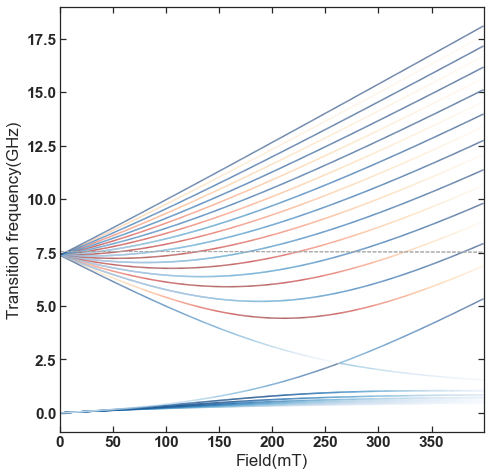

In [9]:
'''This diagonalizes the Hamiltonian matrix for a hydrogen-like spin system and 
gives various useful ESR related plots and values. Scroll down past the functions
section to get to the bit of the program where you tell it what to do'''
################################################
import numpy as np
from scipy.constants import*
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
from colour import Color
from matplotlib.collections import LineCollection
from time import time
import sys
################################################
#Functions
#Write 1/2 integer as fraction
def h_int(n):
    fraction = str(int(n*2))+"/2"
    return (fraction)


#Coefficient when raising operator J+ is applied
def alpha(mz,J):
    alpha = (J*(J+1)-mz*(mz+1))**0.5
    return (alpha)

#Multiplicity of J
def M(J):
    M = int(2*J+1)
    return (M)

#Creates N dimensional identity matrix
def identity (N):

    I = np.zeros((N,N))
    for n in range (N):
        for m in range(N):
            if n==m:
                I[n,m] = 1
    return (I)
            
#Angular momentum operators for angular momentum J
def ang_mo_op(J):
    N=int(2*J+1)
    
    J_plus = np.zeros((N,N))
    J_minus = np.zeros((N,N))
    Jz = np.zeros((N,N))
    
    for n in range (N):
        for m in range(N):
            if n==m+1:
                J_plus[n,m] = alpha(J-n,J)
            if n==m-1:
                J_minus[n,m] = alpha(J-m,J)
            if n==m:
                Jz[n,m] = J-n
    
    Jx = 0.5*(J_plus+J_minus)
    Jy = -0.5*1j*(J_plus-J_minus)
    return (Jx,Jy,Jz)
    
#Electron and nuclear Zeeman terms
def Zeeman(gI,gS,B,Ixb,Iyb,Izb,Sxb,Syb,Szb):
    ub = physical_constants["Bohr magneton"][0]
    un = physical_constants["nuclear magneton"][0]
    H = un*gI*((Ixb*B[0]+Iyb*B[1]+Izb*B[2]))+ub*gS*(Sxb*B[0]+Syb*B[1]+Szb*B[2])
    return (H)

#Hyperfine coupling term    
def HFC(A,Ix,Iy,Iz,Sx,Sy,Sz):
    H = h*A*(prod_IS(Ix,Sx)+prod_IS(Iy,Sy)+prod_IS(Iz,Sz))
    return (H)

#Multiply compenents by identities to enlarge a 2x2 matrix Sx to dimension (2MI)x(2MI)
def enlarge_S(MI,Sx):
    A = (identity(MI)*Sx[0,0])
    B = (identity(MI)*Sx[0,1])
    C = (identity(MI)*Sx[1,0])
    D = (identity(MI)*Sx[1,1])
    Sxb = np.bmat('A,B;C,D')
    return (Sxb)
    
#Enlarges an MIxMI matrix Ix to (2MI)x(2MI)
def enlarge_I(Ix,MI):
    Ixb=np.bmat([[Ix,np.zeros((MI,MI))],[np.zeros((MI,MI)),Ix]])
    return (Ixb)
    
#Kronecker product of a 2x2 matrix Sx with an MIxMI matrix Ix
def prod_IS(Ix,Sx):
    A = (Ix*Sx[0,0])
    B = (Ix*Sx[0,1])
    C = (Ix*Sx[1,0])
    D = (Ix*Sx[1,1])
    IxSx = np.bmat('A,B;C,D')
    return (IxSx)
    
#Plot energy levels against B field (remember to call plt.show afterwards if you want to see it!)
def plot_E_B(I,B_sweep,Bmax,E,save=False):
    
    colour1 = Color("black")
    colour2 = Color("#8c8c8c")
    #sns.set_style("white")
    sns.set(font_scale=1.4, style='ticks')
    sns.set_style({"xtick.direction": "in","ytick.direction": "in",'ytick.right': True,'xtick.top': True})
    MI = M(I)
    top_colours = list(colour2.range_to(colour1,MI))
    bottom_colours = list(colour1.range_to(colour2,MI))
    for n in range(MI*2):
        if (n<MI):
            plt.plot (np.multiply(B_sweep,1000),E[n],label = n, color = str(bottom_colours[n]))
        else:
            plt.plot (np.multiply(B_sweep,1000),E[n],label = n, color = str(top_colours[n-MI]))
    plt.xlabel('B(mT)')
    plt.ylabel('Frequency shift (GHz)')
    plt.title('Energy Levels, I='+str(Fraction(I)))
    #sns.despine()
    #plt.legend()
    #manager = plt.get_current_fig_manager()
    #manager.window.showMaximized()
    if save == True:
        plt.savefig('EB_Plot, I='+str(I)+'.pdf')
    plt.xlim(1000*np.array(B_sweep).min(), 1000*np.array(B_sweep).max())
    print(1000*np.array(B_sweep).max())
    plt.tight_layout()
    plt.show()
    
#Calculate all eigenenergies as a function of B field
def calc_eigenenergies(species,Bmax,Bmin = 0,points = 1000):
    start_time = time()
    #print('calculating eigenenergies...')
    #print(Bmin,Bmax)
    MI = M(species[0])
    H = []
    E = []
    B_sweep = []
    eigenvectors = []

    (Ix,Iy,Iz) = ang_mo_op(species[0])
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(species[1])
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))

    for n in range(MI*2):
        #PrintStatic(str(n))
        E.append([])
    
    for n in range (points):
        PrintStatic(str(n))
        B=[0,0,Bmin+(Bmax-Bmin)/points*n]
        B_sweep.append(B[2])
        H.append(HFC(species[4],Ix,Iy,Iz,Sx,Sy,Sz)+Zeeman(species[3],species[2],B,Ixb,Iyb,Izb,Sxb,Syb,Szb))
        
        (eigval,eigvec)=(np.linalg.eig(H[n]))
        eigenvectors.append([eigvec,eigval])
        for n in range(MI*2):
            E[n].append(np.sort(np.real(eigval))[n]/h/1E9)
    #print('done in %.2fs'%(time()-start_time))
    return (B_sweep,E,eigenvectors)

def FGR_E_transitions(eigvec,species,A_drive = 1):
    MI = M(species[0])
    (Ix,Iy,Iz) = ang_mo_op(species[0])
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(species[1])
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))
    
    Es,gammas,nm = [],[],[]
    
    H_drive = HFC(A_drive,Ix,Iy,Iz,Sx,Sy,Sz)
    H_drive_magnetic = Zeeman(species[3],species[2],[1,0,0],Ixb,Iyb,Izb,Sxb,Syb,Szb)
    
    #print (H_drive.max,H_drive_magnetic.max)
    length = len(np.squeeze(np.asarray(eigvec[0][0,:])))
    
    for n in range(length):
        i = np.squeeze(np.asarray(eigvec[0][:,n]))
        for m in range(n+1,len(i)):
            f = np.squeeze(np.asarray(eigvec[0][:,m]))
            gamma = 1e24*np.abs(np.matmul(f,np.squeeze(np.asarray(np.matmul(H_drive,i)))))
            
            if gamma > 0 :
                Ef = np.real(eigvec[1][m])/h/1E9
                Ei = np.real(eigvec[1][n])/h/1E9
                E=(np.abs(Ef-Ei))
                Es.append([E,gamma,Ef,Ei])
                #print(E)
    
    Es = (np.array(Es))
    Es = Es[Es[:,0].argsort()]
    return(Es[:,0],Es[:,1],Es[:,2],Es[:,3])  

def FGR_transitions(eigvec,species,B_drive = [1,0,0]):
    MI = M(species[0])
    (Ix,Iy,Iz) = ang_mo_op(species[0])
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(species[1])
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))
    
    Es,gammas,nm = [],[],[]
    
    H_drive = Zeeman(species[3],species[2],B_drive,Ixb,Iyb,Izb,Sxb,Syb,Szb)
    length = len(np.squeeze(np.asarray(eigvec[0][0,:])))
    
    for n in range(length):
        i = np.squeeze(np.asarray(eigvec[0][:,n]))
        for m in range(n+1,len(i)):
            f = np.squeeze(np.asarray(eigvec[0][:,m]))
            gamma = 1e24*np.abs(np.matmul(f,np.squeeze(np.asarray(np.matmul(H_drive,i)))))
            
            
            if gamma > 0 :
                Ef = np.real(eigvec[1][m])/h/1E9
                Ei = np.real(eigvec[1][n])/h/1E9
                E=(np.abs(Ef-Ei))
                Es.append([E,gamma,Ef,Ei])
                #print(Ef,Ei)
    
    Es = (np.array(Es))
    #print(Es[:,1].min())
    Es = Es[Es[:,0].argsort()]
    return(Es[:,0],Es[:,1],Es[:,2],Es[:,3])            

def plot_transitions(B_sweep,eigenvectors,species,B_drive = [1,0,0],cmap = "Blues"):    
    #print(species)
    start_time = time()
    print('calculating and plotting transitions...')
    for n in range(len(B_sweep)):
        PrintStatic(str(n))
        E,g,Ef,Ei = FGR_transitions(eigenvectors[n],species,B_drive=B_drive)
        if n ==0: Es,gs,Efs,Eis = E,g,Ef,Ei
        else: Es,gs,Efs,Eis = np.column_stack((Es, E)),np.column_stack((gs, g)),np.column_stack((Efs, Ef)),np.column_stack((Eis, Ei))

    for n in range (len(gs)): plot_multicoloured_line(1000*np.array(B_sweep),Es[n],gs[n]/gs.max(),cmap = cmap)
    #print(gs[10])
    #plt.plot(1000*np.array(B_sweep),gs[n])#
    plt.ylabel('Transition frequency(GHz)')
    plt.xlabel('Field(mT)')  
    plt.xlim(1000*np.array(B_sweep).min(), 1000*np.array(B_sweep).max())
    plt.tight_layout()
    print('done in %.2fs'%(time()-start_time))
    return(Es,gs,Efs,Eis)
    
def plot_E_transitions(B_sweep,eigenvectors,species,A_drive = 1,cmap = "Greens"):    
    
    start_time = time()
    print('calculating and plotting transitions...')
    for n in range(len(B_sweep)):
        #PrintStatic(str(n))
        #print(n)
        E,g,Ef,Ei = FGR_E_transitions(eigenvectors[n],species,A_drive = A_drive)
        #print (E.shape)
        if n ==0: Es,gs,Efs,Eis = E,g,Ef,Ei
        else: Es,gs,Efs,Eis = np.column_stack((Es, E)),np.column_stack((gs, g)),np.column_stack((Efs, Ef)),np.column_stack((Eis, Ei))
    
    #print(Es)
    for n in range (len(gs)): plt.plot(1000*np.array(B_sweep),Es[n])
    #print(gs[10])
    #plt.plot(1000*np.array(B_sweep),gs[n])#
    plt.ylabel('Transition frequency(GHz)')
    plt.xlabel('Field(mT)')  
    plt.xlim(1000*np.array(B_sweep).min(), 1000*np.array(B_sweep).max())
    plt.tight_layout()
    print('done in %.2fs'%(time()-start_time))
    return(Es,gs,Efs,Eis)
    
def get_transitions(B_sweep,eigenvectors,species,B_drive = [1,0,0]):    
    
    start_time = time()
    #print('calculating transitions...')
    for n in range(len(B_sweep)):
        PrintStatic(str(n))
        E,g,Ef,Ei = FGR_transitions(eigenvectors[n],species,B_drive=B_drive)
        if n ==0: Es,gs,Efs,Eis = E,g,Ef,Ei
        else: Es,gs,Efs,Eis = np.column_stack((Es, E)),np.column_stack((gs, g)),np.column_stack((Efs, Ef)),np.column_stack((Eis, Ei))
    #print('done in %.2fs'%(time()-start_time))
    return(Es,gs,Efs,Eis)    

def plot_gradient(B_sweep,transition_energies,gfactor = False):
    colour1 = Color("darkslateblue")
    colour2 = Color("orange")
    colours = list(colour2.range_to(colour1,len(transition_energies)))
    i=0
    for E in transition_energies:
        dfdb = []
        sns.set(font_scale=1.4, style='ticks')
        sns.set_style({"xtick.direction": "in","ytick.direction": "in",'ytick.right': True,'xtick.top': True})
        for n in range(len(E)-1): dfdb.append(np.subtract(E[n],E[n+1])/(B_sweep[1]-B_sweep[0]))
        if gfactor == False:
            plt.plot(np.multiply(B_sweep[:-1],1000),np.abs(dfdb),color = str(colours[i]))
            plt.ylabel('df/dB (GHz/T)')
        else: 
            plt.plot(np.multiply(B_sweep[:-1],1000),-2*np.pi*2E9*m_e*np.array(dfdb)/e,color = str(colours[i]))
            plt.ylabel('g factor')
        i+=1
        #plt.legend(bbox_to_anchor=(0.35, 1))
    plt.xlabel('Field (mT)')
    plt.tight_layout()
        
    plt.show()  

def get_gradient(B_sweep,transition_energies):
    dfdb_array = []
    for E in transition_energies:
        dfdb = []
        for n in range(len(E)-1): dfdb.append(np.subtract(E[n],E[n+1])/(B_sweep[1]-B_sweep[0]))
        dfdb_array.append(dfdb)
    return(dfdb_array)
    
    
def get_E(B_sweep, E, B0, T, show = False):
    GND = E[0][np.abs(np.subtract(B_sweep,B0)).argmin()]
    kb = physical_constants["Boltzmann constant"][0]
    En = []
    Zn = []
    MI = M(species[0])
    for n in range (MI*2):
        En.append(E[n][np.abs(np.subtract(B_sweep,B0)).argmin()]-GND)
        Zn.append(np.exp(-En[n]*h*1E9/(kb*T)))
        if show == True:
            print(En[n],np.exp(-En[n]*h*1E9/(kb*T)))
    return(En, Zn)

def plot_Probabilities(B_sweep, E, B0,Tmin=0,Tmax=0.2):
    Temp = np.linspace(Tmin,Tmax,1001)
    P = []
    MI = M(species[0])
    for n in range (MI*2):
        P.append([])
    levels = np.linspace(0,2*MI-1,2*MI, dtype = int)
    for T in Temp:
        En, Zn = get_E(B_sweep, E, B0,T, False)
        Z = np.sum(Zn)
        for level in levels:
            P[level].append(Zn[level]/Z)
    
    print (np.shape(P))
    sns.set_style('white')
    
    colour1 = Color("darkslateblue")
    colour2 = Color("orange")
    colours = list(colour2.range_to(colour1,MI*2))
    
    for level in levels:
        plt.plot(np.multiply(Temp,1000),P[level], label = level, color = str(colours[level]))
        
    plt.title('Probabilities for electron to be in each level (GND = 0), %.1fmT'%(B0*1000))
    plt.xlabel('Temperature (mK)')
    plt.ylabel('P')
    plt.legend()
    #plt.tight_layout()
    plt.show()
    

def get_populations(B_sweep, E,Ei,Ef, B0,Tmin=0.01,Tmax=0.4):
    kb = physical_constants["Boltzmann constant"][0]
    GND = E[0][np.abs(np.subtract(B_sweep,B0)).argmin()]
    Temp = np.linspace(Tmin,Tmax,391)
    polarisation,population = [],[]
    if Ei>Ef: Ei,Ef = Ef,Ei
 
    #print(Ei,Ef,GND)
    #print("")
    Ei = Ei-GND
    Ef = Ef-GND
    #print(Ei,Ef,GND)
    #print("")
    
    for T in Temp:
        En, Zn = get_E(B_sweep, E, B0,T, False)
        Z = np.sum(Zn)
        Zi = np.exp(-Ei*h*1E9/(kb*T))
        Zf = np.exp(-Ef*h*1E9/(kb*T))
        polarisation.append((Zi-Zf)/(Zi+Zf))
        population.append(Zi/Z)
        #print(T,polarisation[-1],population[-1])
    return(Temp,polarisation,population)
        
        
def get_dfdA(species,B,B_drive = [1,0,0]):
    B_sweep,E,eigenvectors = calc_eigenenergies(species,B,Bmin = B,points = 1)
    TE,gs,TEf,TEi = get_transitions(B_sweep,eigenvectors,species,B_drive = B_drive)
    
    dA = species[4] *0.001
    A = species[4]+dA
    species_prime = [species[0],species[1],species[2],species[3],A]
    
    B_sweep,E,eigenvectors = calc_eigenenergies(species_prime,B,Bmin = B,points = 1)
    TEprime,gs_prime,TEf_prime,TEi_prime = get_transitions(B_sweep,eigenvectors,species,B_drive = B_drive)

    delta_E = np.subtract(TE,TEprime)
    out = []
    for n in range (len(delta_E)):
        #if TE[n]>4: print(delta_E[n]/(dA/1E9), TE[n])
        out.append([delta_E[n]/(dA/1E9),TEf[n],TEi[n]])
        
    return(out)
    
def plot_HFClock(species,Bmax,Bmin = 0,B_drive = [0,0,1],points=1000):
    B_sweep,E,eigenvectors = calc_eigenenergies(species,Bmax,Bmin = Bmin,points = points)
    TE,gs,TEf,TEi = get_transitions(B_sweep,eigenvectors,species,B_drive = B_drive)
    
    dA = species[4] *0.001
    A = species[4]+dA
    species_prime = [species[0],species[1],species[2],species[3],A]
   
    
    B_sweep,E,eigenvectors = calc_eigenenergies(species_prime,Bmax,points = points)
    TEprime,gs_prime,TEf_prime,TEi_prime = get_transitions(B_sweep,eigenvectors,species,B_drive = B_drive)
    
    print(TE.max(),TEprime.max())
    delta_E = np.subtract(TE,TEprime)
    print(delta_E.max())
    colour1 = Color("darkslateblue")
    colour2 = Color("orange")
    colours = list(colour2.range_to(colour1,len(TE)))
    #
    n=0
    for delta_E_i in delta_E:
        plt.plot(np.multiply(B_sweep,1000),delta_E_i/(dA/1E9))
        #if not all(i < 0 for i in delta_E_i) and (TE[n][np.argmin(delta_E_i**2)])>1:
        #    sns.set(font_scale=1.4, style='ticks')
        #    sns.set_style({"xtick.direction": "in","ytick.direction": "in",'ytick.right': True,'xtick.top': True})
        #    plt.plot(np.multiply(B_sweep,1000),delta_E_i/(dA/1E9))
        #    print ("F = %.6fGHz, B = %.2fmT"%(TE[n][np.argmin(delta_E_i**2)],np.multiply(B_sweep[np.argmin(delta_E_i**2)],1000)))
        n=n+1
        
    #plt.legend(bbox_to_anchor=(1, 0.3))
    plt.title('Hyperfine gradient')
    plt.xlabel('Field (mT)')
    plt.ylabel('df/dA')
    plt.show()    
   
def track_fn(x, a, b, c):
    return (a*x**2 +b*x+c)

def quadratic_fit(x0,y0,start = 0, stop = None,colour = '#23c161'):
    from lmfit.models import QuadraticModel
    x = x0[start:stop]
    y = y0[start:stop]
    quad_mod = QuadraticModel()
    pars = quad_mod.guess(y, x=x)
    out  = quad_mod.fit(y,pars,x=x)
    a,b,c = out.params['a'],out.params['b'],out.params['c']
    print(a.value,b.value,c.value)
    x_fit = np.linspace(min(x),max(x),100)
    y_fit = a*x_fit**2+b*x_fit+c
    x0_fit = np.linspace(min(x0),max(x0),100)
    y0_fit = a*x0_fit**2+b*x0_fit+c
    plt.plot(x_fit,y_fit,color = colour)
    plt.plot(x0_fit,y0_fit,'--',color = colour)
    return()


def plot_resonator(B_sweep,E,transition_energies,gammas,Efs,Eis,tracking_params,species,B_drive = [1,0,0],colour = None, legend = False):
    freqs = []
    B_sweep_fine = np.linspace(min(B_sweep),max(B_sweep),10001)
    freqs=[track_fn(B,*tracking_params) for B in B_sweep_fine]
    plt.plot(np.multiply(B_sweep_fine,1000),freqs,"--",color = colour,linewidth = 1)#,label = '%gGHz Resonator'%round(freqs[0],3))
    if legend == True: plt.legend(prop={"size": 10},frameon=False)
    
    crossings = []
    for n in range(len(transition_energies)):
        
        t = np.interp(B_sweep_fine,B_sweep,transition_energies[n])
        gamma = np.interp(B_sweep_fine,B_sweep,gammas[n])
        ti = np.interp(B_sweep_fine,B_sweep,Eis[n])
        tf = np.interp(B_sweep_fine,B_sweep,Efs[n])
            
        dfdb = np.array(get_gradient(B_sweep_fine,[t])[0])
        diff = np.subtract(t,freqs)
        zero_crossings = np.where(np.diff(np.sign(diff)))[0]
        if len(zero_crossings) >0:
            
            for zero_crossing in zero_crossings:
                
                out = np.array(get_dfdA(species,B_sweep_fine[zero_crossing],B_drive = B_drive))
                #print(out[:,2],ti[zero_crossing])
                for dfdA in out:
                    
                    if np.abs(np.subtract(dfdA[2],ti[zero_crossing]))<1e-5 and np.abs(np.subtract(dfdA[1],tf[zero_crossing]))<1e-5:
                        dfdA_0 = (dfdA[0])
                g = np.around(-dfdb/28.02495164,2)[zero_crossing]
                
                Temp,polarisation,population = get_populations(B_sweep, E,ti[zero_crossing], tf[zero_crossing],0.2,Tmin=0.01,Tmax=0.4)
                pop_pol = np.multiply(population,1)#polarisation)
                
                crossings.append([np.around(B_sweep_fine[zero_crossing]*1000,2),np.around(freqs[zero_crossing],6),
                g,np.around(gamma[zero_crossing],2),np.around(dfdA_0,4),np.around(np.max(pop_pol),4),Temp[np.argmax(pop_pol)]])
                
    crossings = np.array(crossings)
    
    crossings = crossings[crossings[:,3].argsort()]

    print("Resonator-Spin crossings\nField(mT)\tFrequency(GHz)\tgamma/gamma_e\tMatrix element\tdf/dA\t\tP max\t\tOptimum Temp (K)")
    for crossing in crossings: print("{:g}\t\t{:g}\t\t{:g}\t\t{:g}\t\t{:g}\t\t{:g}\t\t{:g}".format(crossing[0],crossing[1],crossing[2],crossing[3],crossing[4],crossing[5],crossing[6]))
    print("")
    
    return(crossings)
       
def PrintStatic(s):
    sys.stdout.write(s + " " * (78 - len(s)) + "\r")
    
def plot_multicoloured_line(x,y,c,cmap = "Blues"):
    # set up a list of (x,y) points
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    #print (points.shape)  # Out: (len(x),1,2)
    
    # set up a list of segments
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    #print (segs.shape)  # Out: ( len(x)-1, 2, 2 )
                    # see what we've done here -- we've mapped our (x,y)
                    # points to an array of segment start/end coordinates.
                    # segs[i,0,:] == segs[i-1,1,:]
    
    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap(cmap),alpha = 0.6)
    lc.set_array(c) # color the segments by our parameter
    
    sns.set(font_scale=1.4, style='ticks')
    sns.set_style({"xtick.direction": "in","ytick.direction": "in",'ytick.right': True,'xtick.top': True})
    # plot the collection
    plt.gca().add_collection(lc) # add the collection to the plot


################################################
#Put system parameters here
Bmax = 0.4                                                       #Max B field in Tesla
mendoza0  = [-0.19307464631,0.00010096675,7.54741534102]     #0-80mT 
mendoza3  = [-0.11126923759,0.00131640107,5.23022090726]
mendoza1  = [-0.1711687,0.000297,7.07416098]                #15-35mT
test_res  = [-0.11126923759,0.00131640107,5.23022090726]

chocobot0 = [-0.13149581522,0.00007915630,6.76421816778]     # 0-100mT

#species   = [I  ,J  ,gS     ,gI    ,A(Hz)    ]
bismuth    = [9/2,1/2,2.00032,0.9135,1475.17E6]                     #Define spin species here
phosphorus = [1/2,1/2,1.9985 ,0.9135,117.53E6 ]
#test       = [9/2,1/2,2.00032,0.9135,1000E6] 
species = bismuth                                           #Choose spin species here
#################################################
#This is where you tell the program to do stuff
start_time = time()

figx,figy = 7,7
plt.figure(figsize = (figx,figy))
#print(Bmax)
B_sweep,E,eigenvectors = calc_eigenenergies(species,Bmax,Bmin = 0.0, points = 400)                        #Call this function first to get eigenenergies

#print(B_sweep)

# plot_E_B(species[0],B_sweep,Bmax,E)

Ezs,gzs,Efzs,Eizs = plot_transitions(B_sweep,eigenvectors,species,B_drive = [0,0,1],cmap = "OrRd")       #Parallel transitions (z axis drive)
Exs,gxs,Efxs,Eixs = plot_transitions(B_sweep,eigenvectors,species,B_drive = [1,0,0],cmap = "Blues")      #Perpendicular transitions (x or y axis drive)
# #
# #print('Total time %.2fs'%(time()-start_time))
# #
crossings = plot_resonator(B_sweep,E,Ezs,gzs,Efzs,Eizs,mendoza0,species,B_drive = [0,0,1],colour = 'darkgrey')
crossings = plot_resonator(B_sweep,E,Exs,gxs,Efxs,Eixs,mendoza0,species,B_drive = [1,0,0],colour = 'darkgrey')
# #
# plt.ylim(0,Exs.max())

# res = track_fn(np.array(B_sweep),*mendoza0)
# plt.ylim(res.min()-0.1*res.ptp(),res.max()+0.1*res.ptp())

# #plt.legend(loc = "lower right",prop={"size": 15},frameon=False)
# #plt.legend(bbox_to_anchor = (1,1.25),prop={"size": 15},frameon=False)
# plt.ylabel('Frequency(GHz)')
# plt.tight_layout()
# #plt.xlim(160,280)
# #
# plt.show()
#
#transitions_list, transition_energies = get_clock(E, B_sweep, show = False)                   #Gets transitions, identifies clock transitions (uses selection rules)
#plot_E_B (species[0],B_sweep,Bmax,E,save = False)                                             #Plots Breit-Rabi Diagram
#plot_gradient(B_sweep,Ezs,gfactor = True)                                                     #Plots transition df/dB
#plot_Probabilities(B_sweep, E, B0=0.1,Tmin=0,Tmax=0.5)                                      #Calculates partition function and plots probabilities to be in each level
#plot_HFClock(species,Bmax,points = 400,B_drive = [1,0,0])                                                       #Plots Hyperfine clock transitions
#out = np.array(get_dfdA(species,0.36883,B_drive = [1,0,0]))
#for n in range (len(out)):
#    if print(out[n,0])

# print(crossings[5][5],crossings[5][6])
# Temp,polarisation,population = get_populations(B_sweep, E,crossings[5][5],crossings[5][6], 0.2,Tmin=0.01,Tmax=0.4)
# plt.plot(Temp,np.multiply(polarisation,population))
# plt.show()

calculating and plotting transitions...


done in 1.67s                                                                 


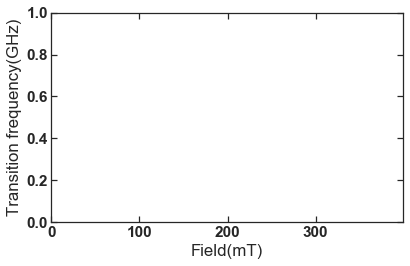

In [2]:
################################################
#Put system parameters here
Bmax = 0.4                                                       #Max B field in Tesla
mendoza0  = [-0.19307464631,0.00010096675,7.54741534102]     #0-80mT 
mendoza3  = [-0.11126923759,0.00131640107,5.23022090726]
mendoza1  = [-0.1711687,0.000297,7.07416098]                #15-35mT
test_res  = [-0.11126923759,0.00131640107,5.23022090726]

chocobot0 = [-0.13149581522,0.00007915630,6.76421816778]     # 0-100mT

#species   = [I  ,J  ,gS     ,gI    ,A(Hz)    ]
bismuth    = [9/2,1/2,2.00032,0.9135,1475.17E6]                     #Define spin species here
phosphorus = [1/2,1/2,1.9985 ,0.9135,117.53E6 ]
#test       = [9/2,1/2,2.00032,0.9135,1000E6] 
species = bismuth                                           #Choose spin species here
#################################################
#This is where you tell the program to do stuff
start_time = time()

# figx,figy = 7,7
# plt.figure(figsize = (figx,figy))
#print(Bmax)
B_sweep,E,eigenvectors = calc_eigenenergies(species,Bmax,Bmin = 0.0, points = 400)  #Call this function first to get eigenenergies

# print(B_sweep)

# plot_E_B(species[0],B_sweep,Bmax,E)

Ezs,gzs,Efzs,Eizs = plot_transitions(B_sweep,eigenvectors,species,B_drive = [0,0,1],cmap = "OrRd")       #Parallel transitions (z axis drive)
# Exs,gxs,Efxs,Eixs = plot_transitions(B_sweep,eigenvectors,species,B_drive = [1,0,0],cmap = "Blues")      #Perpendicular transitions (x or y axis drive)
# 
# #
# #print('Total time %.2fs'%(time()-start_time))
# #
# crossings = plot_resonator(B_sweep,E,Ezs,gzs,Efzs,Eizs,mendoza0,species,B_drive = [0,0,1],colour = 'darkgrey')
# crossings = plot_resonator(B_sweep,E,Exs,gxs,Efxs,Eixs,mendoza0,species,B_drive = [1,0,0],colour = 'darkgrey')
# #
# plt.ylim(0,Exs.max())

# res = track_fn(np.array(B_sweep),*mendoza0)
# plt.ylim(res.min()-0.1*res.ptp(),res.max()+0.1*res.ptp())

#plt.legend(loc = "lower right",prop={"size": 15},frameon=False)
#plt.legend(bbox_to_anchor = (1,1.25),prop={"size": 15},frameon=False)
# plt.ylabel('Frequency(GHz)')
# plt.tight_layout()
#plt.xlim(160,280)
#
# plt.show()
# #
# #transitions_list, transition_energies = get_clock(E, B_sweep, show = False)                   #Gets transitions, identifies clock transitions (uses selection rules)
# #plot_E_B (species[0],B_sweep,Bmax,E,save = False)                                             #Plots Breit-Rabi Diagram
# #plot_gradient(B_sweep,Ezs,gfactor = True)                                                     #Plots transition df/dB
# #plot_Probabilities(B_sweep, E, B0=0.1,Tmin=0,Tmax=0.5)                                      #Calculates partition function and plots probabilities to be in each level
# #plot_HFClock(species,Bmax,points = 400,B_drive = [1,0,0])                                                       #Plots Hyperfine clock transitions
# #out = np.array(get_dfdA(species,0.36883,B_drive = [1,0,0]))
# #for n in range (len(out)):
# #    if print(out[n,0])

# print(crossings[5][5],crossings[5][6])
# Temp,polarisation,population = get_populations(B_sweep, E,crossings[5][5],crossings[5][6], 0.2,Tmin=0.01,Tmax=0.4)
# plt.plot(Temp,np.multiply(polarisation,population))
# plt.show()

In [15]:
plot_E_transitions(B_sweep,eigenvectors,species,A_drive = 100,cmap = "Greens")

calculating and plotting transitions...


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 8 and the array at index 1 has size 9

In [ ]:
def FGR_E_transitions(eigvec,species,A_drive = 1):
    MI = M(species[0])
    (Ix,Iy,Iz) = ang_mo_op(species[0])
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(species[1])
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))
    
    Es,gammas,nm = [],[],[]
    
    H_drive = HFC(A_drive,Ix,Iy,Iz,Sx,Sy,Sz)
    H_drive_magnetic = Zeeman(species[3],species[2],[1,0,0],Ixb,Iyb,Izb,Sxb,Syb,Szb)
    
    #print (H_drive.max,H_drive_magnetic.max)
    length = len(np.squeeze(np.asarray(eigvec[0][0,:])))
    
    for n in range(length):
        i = np.squeeze(np.asarray(eigvec[0][:,n]))
        for m in range(n+1,len(i)):
            f = np.squeeze(np.asarray(eigvec[0][:,m]))
            gamma = 1e24*np.abs(np.matmul(f,np.squeeze(np.asarray(np.matmul(H_drive,i)))))
            
            if gamma > 0 :
                Ef = np.real(eigvec[1][m])/h/1E9
                Ei = np.real(eigvec[1][n])/h/1E9
                E=(np.abs(Ef-Ei))
                Es.append([E,gamma,Ef,Ei])
                #print(E)
    
    Es = (np.array(Es))
    Es = Es[Es[:,0].argsort()]
    return(Es[:,0],Es[:,1],Es[:,2],Es[:,3])  

def FGR_transitions(eigvec,species,B_drive = [1,0,0]):
    MI = M(species[0])
    (Ix,Iy,Iz) = ang_mo_op(species[0])
    (Ixb,Iyb,Izb) = (enlarge_I(Ix,MI),enlarge_I(Iy,MI),enlarge_I(Iz,MI))
    
    (Sx,Sy,Sz) = ang_mo_op(species[1])
    (Sxb,Syb,Szb) = (enlarge_S(MI,Sx),enlarge_S(MI,Sy),enlarge_S(MI,Sz))
    
    Es,gammas,nm = [],[],[]
    
    H_drive = Zeeman(species[3],species[2],B_drive,Ixb,Iyb,Izb,Sxb,Syb,Szb)
    length = len(np.squeeze(np.asarray(eigvec[0][0,:])))
    
    for n in range(length):
        i = np.squeeze(np.asarray(eigvec[0][:,n]))
        for m in range(n+1,len(i)):
            f = np.squeeze(np.asarray(eigvec[0][:,m]))
            gamma = 1e24*np.abs(np.matmul(f,np.squeeze(np.asarray(np.matmul(H_drive,i)))))
            
            
            if gamma > 0 :
                Ef = np.real(eigvec[1][m])/h/1E9
                Ei = np.real(eigvec[1][n])/h/1E9
                E=(np.abs(Ef-Ei))
                Es.append([E,gamma,Ef,Ei])
                #print(Ef,Ei)
    
    Es = (np.array(Es))
    #print(Es[:,1].min())
    Es = Es[Es[:,0].argsort()]
    return(Es[:,0],Es[:,1],Es[:,2],Es[:,3])            

def plot_transitions(B_sweep,eigenvectors,species,B_drive = [1,0,0],cmap = "Blues"):    
    #print(species)
    start_time = time()
    print('calculating and plotting transitions...')
    for n in range(len(B_sweep)):
        PrintStatic(str(n))
        E,g,Ef,Ei = FGR_transitions(eigenvectors[n],species,B_drive=B_drive)
        if n ==0: Es,gs,Efs,Eis = E,g,Ef,Ei
        else: Es,gs,Efs,Eis = np.column_stack((Es, E)),np.column_stack((gs, g)),np.column_stack((Efs, Ef)),np.column_stack((Eis, Ei))

    for n in range (len(gs)): plot_multicoloured_line(1000*np.array(B_sweep),Es[n],gs[n]/gs.max(),cmap = cmap)
    #print(gs[10])
    #plt.plot(1000*np.array(B_sweep),gs[n])#
    plt.ylabel('Transition frequency(GHz)')
    plt.xlabel('Field(mT)')  
    plt.xlim(1000*np.array(B_sweep).min(), 1000*np.array(B_sweep).max())
    plt.tight_layout()
    print('done in %.2fs'%(time()-start_time))
    return(Es,gs,Efs,Eis)
    
def plot_E_transitions(B_sweep,eigenvectors,species,A_drive = 1,cmap = "Greens"):    
    
    start_time = time()
    print('calculating and plotting transitions...')
    for n in range(len(B_sweep)):
        #PrintStatic(str(n))
        #print(n)
        E,g,Ef,Ei = FGR_E_transitions(eigenvectors[n],species,A_drive = A_drive)
        #print (E.shape)
        if n ==0: Es,gs,Efs,Eis = E,g,Ef,Ei
        else: Es,gs,Efs,Eis = np.column_stack((Es, E)),np.column_stack((gs, g)),np.column_stack((Efs, Ef)),np.column_stack((Eis, Ei))
    
    #print(Es)
    for n in range (len(gs)): plt.plot(1000*np.array(B_sweep),Es[n])
    #print(gs[10])
    #plt.plot(1000*np.array(B_sweep),gs[n])#
    plt.ylabel('Transition frequency(GHz)')
    plt.xlabel('Field(mT)')  
    plt.xlim(1000*np.array(B_sweep).min(), 1000*np.array(B_sweep).max())
    plt.tight_layout()
    print('done in %.2fs'%(time()-start_time))
    return(Es,gs,Efs,Eis)